Enter board size (N for NxN board): 10
Select game mode:
1. LLM vs. LLM
2. LLM vs. Human
Enter 1 or 2: 1
Run simulation of 500 games? (y/n): y
Simulation outcomes saved to Exercise1.json
Estimated probability of LLM1 (ChatGPT) win: 0.51


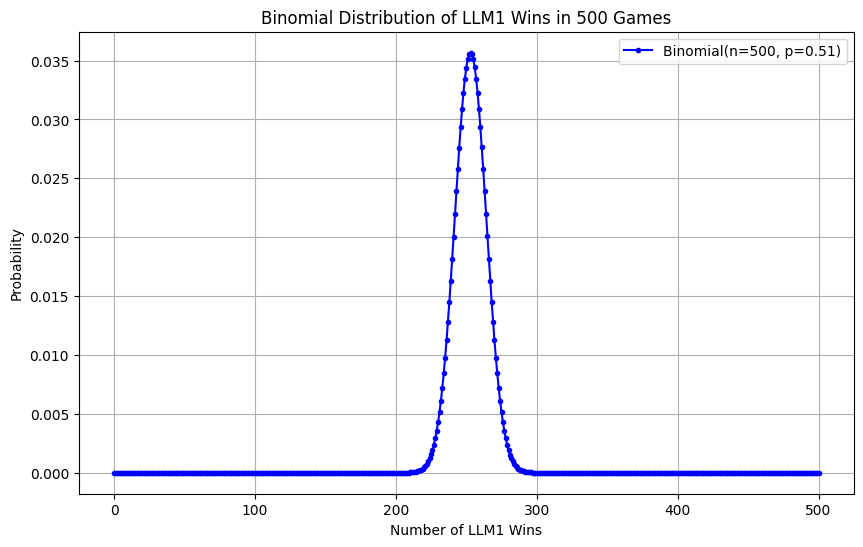

Binomial distribution plot saved as Exercise1.png


In [19]:
import random
import json
import matplotlib.pyplot as plt
import numpy as np
import math

try:
    from scipy.stats import binom
    SCIPY_AVAILABLE = True
except ImportError:
    SCIPY_AVAILABLE = False

class Board:
    def __init__(self, n):
        self.n = n
        self.board = [[' ' for _ in range(n)] for _ in range(n)]

    def make_move(self, row, col, symbol):
        """Place the symbol on the board at (row, col) if that cell is empty."""
        if self.board[row][col] == ' ':
            self.board[row][col] = symbol
            return True
        return False

    def available_moves(self):
        """Return a list of (row, col) tuples where the board is empty."""
        moves = []
        for i in range(self.n):
            for j in range(self.n):
                if self.board[i][j] == ' ':
                    moves.append((i, j))
        return moves

    def check_win(self, symbol):
        """Check if the given symbol has filled any row, column, or diagonal."""

        for row in self.board:
            if all(cell == symbol for cell in row):
                return True

        for col in range(self.n):
            if all(self.board[row][col] == symbol for row in range(self.n)):
                return True

        if all(self.board[i][i] == symbol for i in range(self.n)):
            return True

        if all(self.board[i][self.n - 1 - i] == symbol for i in range(self.n)):
            return True
        return False

    def is_full(self):
        """Return True if the board has no empty cells."""
        return all(self.board[i][j] != ' ' for i in range(self.n) for j in range(self.n))

    def __str__(self):
        """Return a string representation of the board."""
        board_str = ""
        for row in self.board:
            board_str += "|".join(row) + "\n"
        return board_str

def get_llm_move(board_obj, last_move, model_name, symbol, opponent_symbol):
    """
    Simulate an LLM agent's move.

    The agent is given:
      - The current board state.
      - The opponent's last move (if any).
      - Its own symbol and the opponent's symbol.
    The prompt (simulated below) instructs the agent to choose its next move.
    A simple heuristic is used:
      1. If a winning move exists, take it.
      2. If the opponent is about to win, block that move.
      3. Otherwise, select a random available move.
    """
    prompt = f"You are {model_name}.\n"
    prompt += "The current board state is:\n" + str(board_obj)
    if last_move is not None:
        prompt += f"The last move by your opponent was at position {last_move}.\n"
    prompt += f"Your symbol is '{symbol}'. Please choose your next move as a tuple (row, col) with indices starting from 0."

    moves = board_obj.available_moves()

    for move in moves:
        board_obj.board[move[0]][move[1]] = symbol
        if board_obj.check_win(symbol):
            board_obj.board[move[0]][move[1]] = ' '
            return move
        board_obj.board[move[0]][move[1]] = ' '

    for move in moves:
        board_obj.board[move[0]][move[1]] = opponent_symbol
        if board_obj.check_win(opponent_symbol):
            board_obj.board[move[0]][move[1]] = ' '
            return move
        board_obj.board[move[0]][move[1]] = ' '

    return random.choice(moves)

def get_human_move(board_obj):
    """Prompt the human player to enter a move as 'row,col'."""
    moves = board_obj.available_moves()
    move = None
    while move not in moves:
        try:
            user_input = input("Enter your move as row,col (e.g., 0,1): ")
            parts = user_input.split(',')
            if len(parts) != 2:
                print("Invalid input. Please use the format row,col")
                continue
            row, col = int(parts[0].strip()), int(parts[1].strip())
            move = (row, col)
            if move not in moves:
                print("That cell is not available. Please choose a different move.")
        except Exception:
            print("Invalid input, please try again.")
    return move

def play_game(board_size, mode="LLM_vs_LLM"):
    """
    Simulate a single game of tic-tac-toe.

    mode can be:
      - "LLM_vs_LLM": Two simulated LLM agents play.
          * LLM1 is ChatGPT with symbol 'X' and LLM2 is Claude with symbol 'O'.
      - "LLM_vs_Human": ChatGPT (LLM) plays as 'X' against a human as 'O'.

    Returns:
      - winner: 1 if player1 wins, 2 if player2 wins.
      - board_obj: the final board state.

    Note: To enforce a binary outcome in simulation (so that each game counts as a Bernoulli trial),
          if the board fills up without a win, a winner is randomly chosen.
    """
    board_obj = Board(board_size)
    current_player = 1  # 1 for first player, 2 for second player
    last_move = None

    # Define players and their move functions.
    if mode == "LLM_vs_LLM":
        # Player 1: ChatGPT ('X'); Player 2: Claude ('O')
        player1 = {"model": "ChatGPT", "symbol": "X", "opponent_symbol": "O"}
        player2 = {"model": "Claude", "symbol": "O", "opponent_symbol": "X"}
        get_move_funcs = {
            1: lambda board, last: get_llm_move(board, last, player1["model"], player1["symbol"], player1["opponent_symbol"]),
            2: lambda board, last: get_llm_move(board, last, player2["model"], player2["symbol"], player2["opponent_symbol"])
        }
    elif mode == "LLM_vs_Human":
        # Player 1: ChatGPT (LLM) as 'X'; Player 2: Human as 'O'
        player1 = {"model": "ChatGPT", "symbol": "X", "opponent_symbol": "O"}
        player2 = {"model": "Human", "symbol": "O", "opponent_symbol": "X"}
        get_move_funcs = {
            1: lambda board, last: get_llm_move(board, last, player1["model"], player1["symbol"], player1["opponent_symbol"]),
            2: lambda board, last: get_human_move(board)
        }
    else:
        raise ValueError("Invalid game mode.")

    while True:
        current_symbol = player1["symbol"] if current_player == 1 else player2["symbol"]
        move = get_move_funcs[current_player](board_obj, last_move)
        board_obj.make_move(move[0], move[1], current_symbol)
        last_move = move

        if board_obj.check_win(current_symbol):
            winner = current_player
            break
        if board_obj.is_full():
            winner = random.choice([1, 2])
            break
        current_player = 2 if current_player == 1 else 1

    return winner, board_obj

def main():
    try:
        board_size = int(input("Enter board size (N for NxN board): "))
    except ValueError:
        print("Invalid board size. Exiting.")
        return

    print("Select game mode:")
    print("1. LLM vs. LLM")
    print("2. LLM vs. Human")
    mode_choice = input("Enter 1 or 2: ").strip()

    if mode_choice == "1":
        simulation_choice = input("Run simulation of 500 games? (y/n): ").strip().lower()
        if simulation_choice == "y":
            outcomes = []
            for i in range(500):
                winner, _ = play_game(board_size, mode="LLM_vs_LLM")
                outcomes.append(1 if winner == 1 else 0)
            with open("Exercise1.json", "w") as f:
                json.dump(outcomes, f)
            print("Simulation outcomes saved to Exercise1.json")
            p_est = sum(outcomes) / 500
            print(f"Estimated probability of LLM1 (ChatGPT) win: {p_est:.2f}")

            # Plotting the binomial distribution for n=500, p=p_est.
            x = np.arange(0, 501)
            if SCIPY_AVAILABLE:
                pmf = binom.pmf(x, 500, p_est)
            else:
                pmf = [math.comb(500, k) * (p_est * k) * ((1 - p_est) * (500 - k)) for k in x]
            plt.figure(figsize=(10, 6))
            plt.plot(x, pmf, 'b-', marker='.', label=f'Binomial(n=500, p={p_est:.2f})')
            plt.title('Binomial Distribution of LLM1 Wins in 500 Games')
            plt.xlabel('Number of LLM1 Wins')
            plt.ylabel('Probability')
            plt.legend()
            plt.grid(True)
            plt.savefig("Exercise1.png")
            plt.show()
            print("Binomial distribution plot saved as Exercise1.png")
        else:
            # LLM vs. LLM game
            winner, final_board = play_game(board_size, mode="LLM_vs_LLM")
            print("Final Board State:")
            print(final_board)
            if winner == 1:
                print("LLM1 (ChatGPT) wins!")
            else:
                print("LLM2 (Claude) wins!")
    elif mode_choice == "2":
        # LLM vs. Human game
        winner, final_board = play_game(board_size, mode="LLM_vs_Human")
        print("Final Board State:")
        print(final_board)
        if winner == 1:
            print("LLM (ChatGPT) wins!")
        else:
            print("Human wins!")
    else:
        print("Invalid mode selected. Exiting.")

if __name__== "__main__":
    main()